**Import Libraries**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report

**Load the Dataset**

In [2]:
# Load data (replace path with your dataset)
df = pd.read_csv('/content/diabetes.csv')

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None


In [5]:
print(df.describe())

       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  

**EDA**

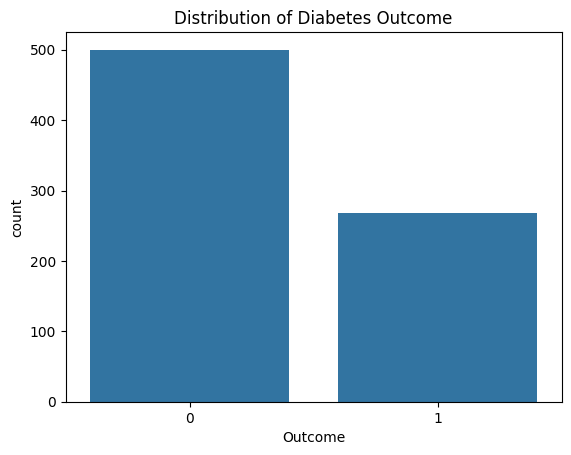

In [6]:
# Check target distribution
sns.countplot(x='Outcome', data=df)
plt.title('Distribution of Diabetes Outcome')
plt.show()

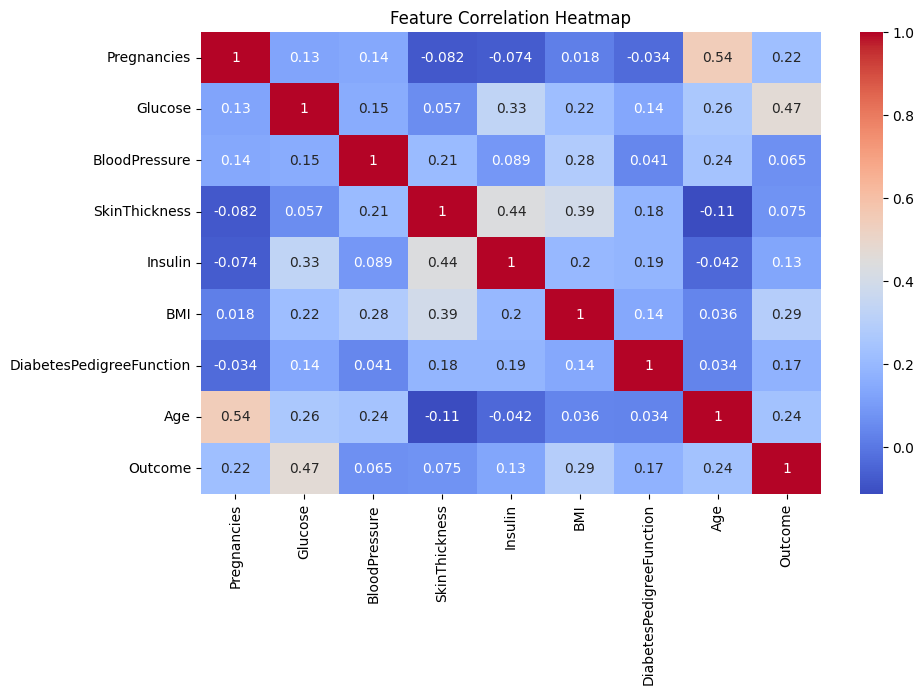

In [7]:
# Correlation heatmap to see relationships
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

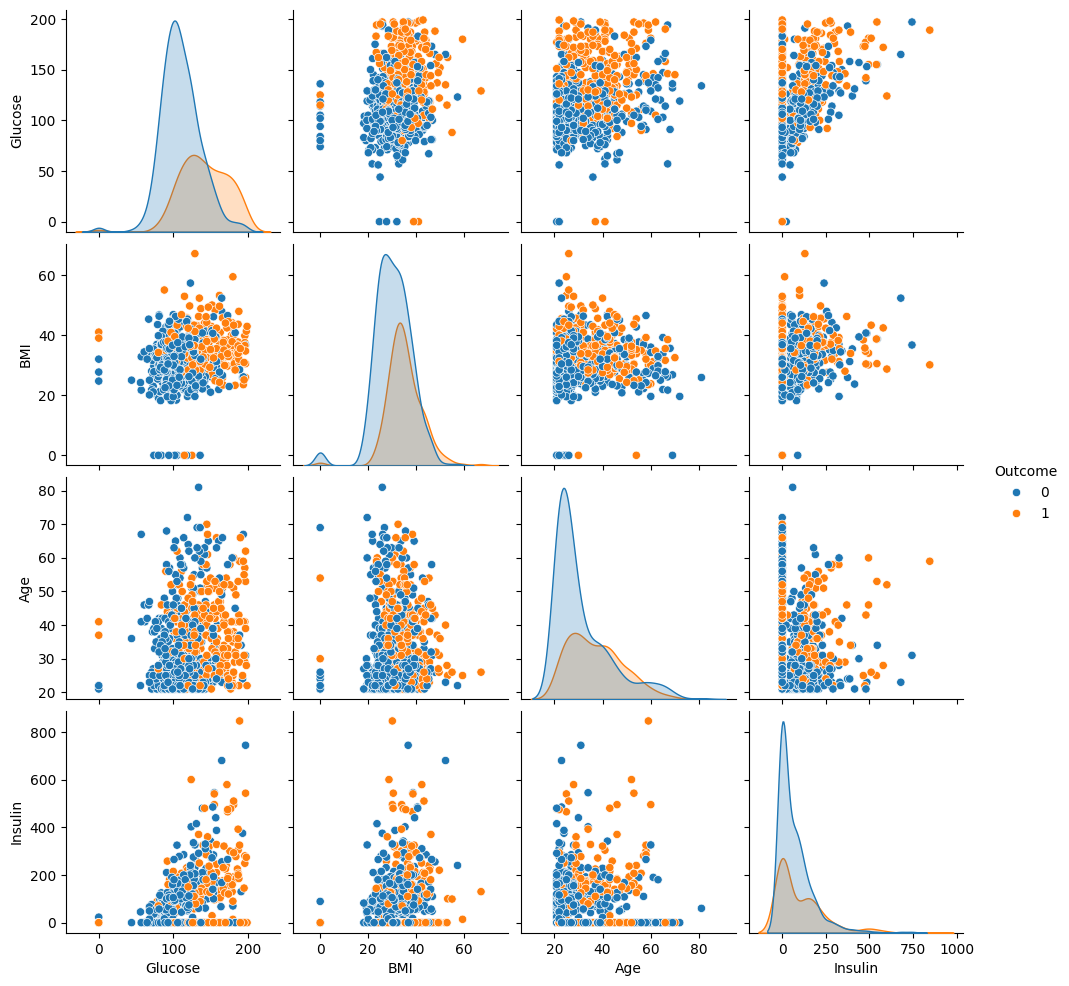

In [8]:
# Pairplot for key features
sns.pairplot(df, hue='Outcome', vars=['Glucose', 'BMI', 'Age', 'Insulin'])
plt.show()

**Data Cleaning and Feature Engineering**

In [9]:
# Features where zero is invalid
features_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

for feature in features_with_zero:
    df[feature] = df[feature].replace(0, np.nan)
    median_val = df[feature].median()
    df[feature] = df[feature].fillna(median_val)

print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


**Feature Selection and Scaling**

In [10]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [11]:
# Feature selection - Select top 5 features based on ANOVA F-test
selector = SelectKBest(score_func=f_classif, k=5)
X_new = selector.fit_transform(X, y)

selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['Pregnancies', 'Glucose', 'SkinThickness', 'BMI', 'Age'], dtype='object')


In [22]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [23]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

**Train Gradient Boosting Model**

In [24]:
# Train model
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

GradientBoostingClassifier(random_state=42)

**Evaluate Model Performance**

In [25]:
# Predictions
y_pred = gb_model.predict(X_test)
y_prob = gb_model.predict_proba(X_test)[:, 1]

In [26]:
# Metrics
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("F1 Score:", round(f1, 3))
print("AUC-ROC:", round(auc, 3))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

F1 Score: 0.673
AUC-ROC: 0.819

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.80      0.81        99
           1       0.66      0.69      0.67        55

    accuracy                           0.76       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.76      0.76      0.76       154



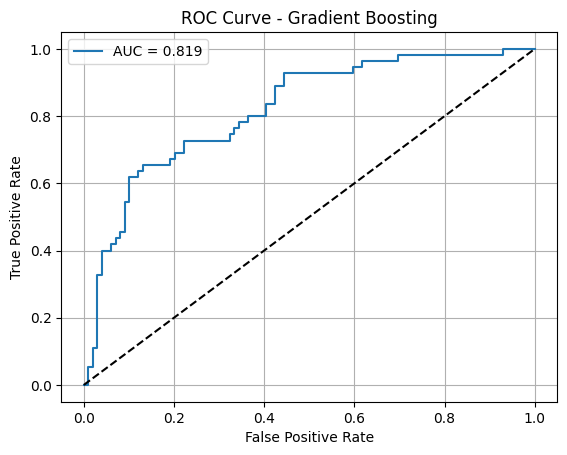

In [27]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend()
plt.grid()
plt.show()

**Feature Importance & Healthcare Insight**

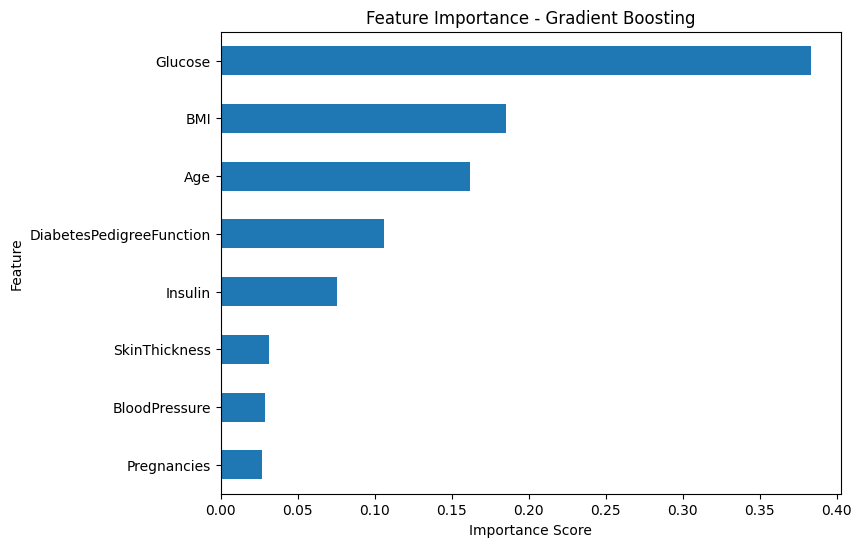

In [28]:
# Now use all 8 column names
feature_importance = pd.Series(gb_model.feature_importances_, index=X.columns)

# Plot
feature_importance.sort_values().plot(kind='barh', figsize=(8,6))
plt.title("Feature Importance - Gradient Boosting")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()